In [1]:
%load_ext autoreload
%autoreload 2
import sys 
sys.path.append('../src/')

In [2]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Toy

In [3]:
from dasbm.data import DiscreteGaussianDataset, DiscreteSwissRollDataset
from dasbm.data import Prior
from dasbm.models.toy import D3PM

## Data

In [4]:
num_samples = 1024

num_categories = 50
num_timesteps = 10
num_skip_steps = 1

In [5]:
dataset_x = DiscreteSwissRollDataset(num_samples, noise=0.8, num_categories=num_categories, train=False)[5:]
dataset_y = DiscreteGaussianDataset(num_samples, dim=2, num_categories=num_categories, train=False)[5:]

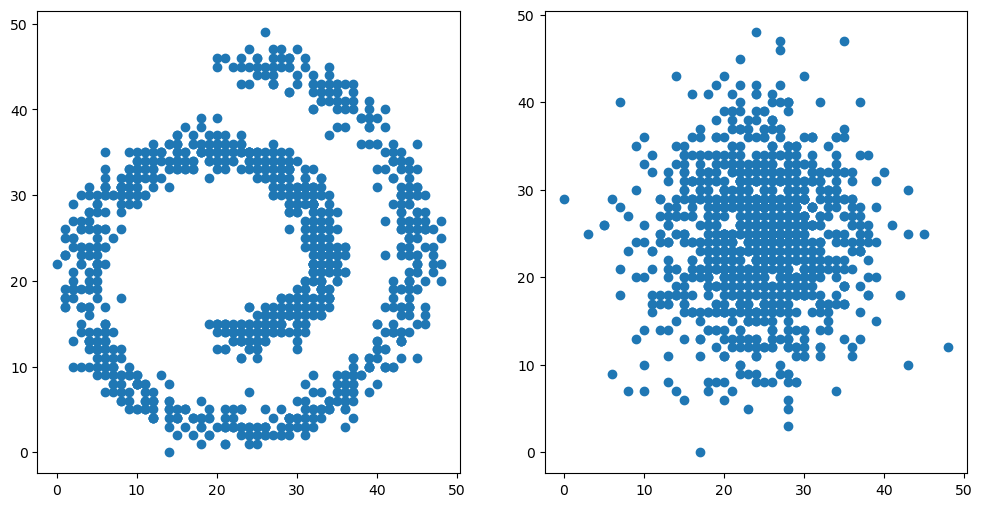

In [6]:
_, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].scatter(dataset_x[:, 0], dataset_x[:, 1])
axs[1].scatter(dataset_y[:, 0], dataset_y[:, 1])
plt.show()

## Prior

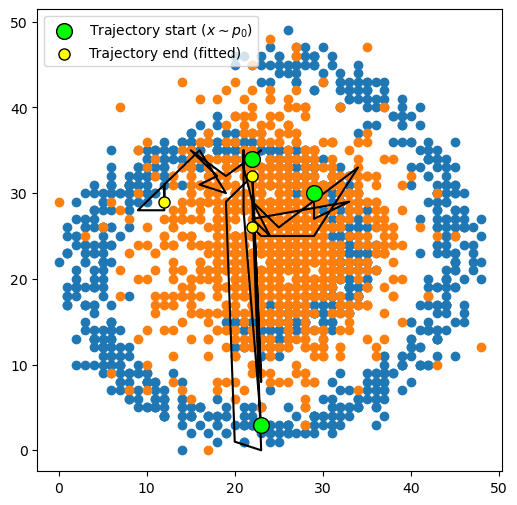

In [57]:
alpha = 0.1
prior_type = 'gaussian'

prior = Prior(
    alpha=alpha, 
    num_categories=num_categories, 
    num_timesteps=num_timesteps, 
    num_skip_steps=num_skip_steps,
    prior_type=prior_type
)
x_start = dataset_x[:3]
x_end = dataset_y[:3]
bridge_samples = []
bridge_samples.append(x_start)
for timestep in range(1, num_timesteps + 1):
    t = torch.full((3, 1), timestep)
    x_t = prior.sample_bridge(x_start, x_end, t)
    bridge_samples.append(x_t)
    # break
bridge_samples.append(x_end)
bridge_samples = torch.stack(bridge_samples, dim=0)

_, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(x_start[:, 0], x_start[:, 1], c="lime", s=128, edgecolors="black", label = r"Trajectory start ($x \sim p_0$)", zorder=3)
ax.scatter(x_end[:, 0], x_end[:, 1], c="yellow", s=64, edgecolors="black", label = r"Trajectory end (fitted)", zorder=3)
for i in range(3):
    ax.plot(bridge_samples[::1, i, 0], bridge_samples[::1, i, 1], "black", markeredgecolor="black", linewidth=1.5, zorder=2)

ax.scatter(dataset_x[:, 0], dataset_x[:, 1])
ax.scatter(dataset_y[:, 0], dataset_y[:, 1])
plt.legend()
plt.show()

In [58]:
x_t.shape

torch.Size([3, 2])

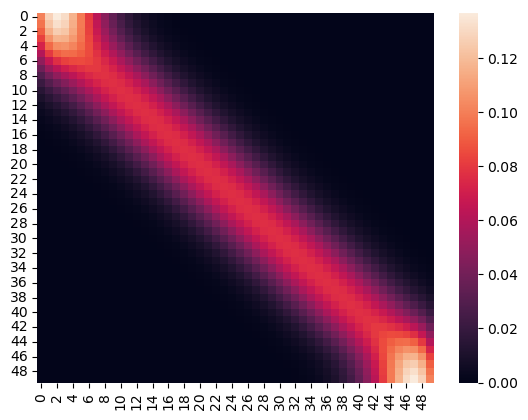

tensor([0.6806, 0.8931, 1.0179, 1.0661, 1.0732, 1.0655, 1.0542, 1.0430, 1.0329,
        1.0242, 1.0173, 1.0119, 1.0079, 1.0050, 1.0031, 1.0019, 1.0011, 1.0006,
        1.0003, 1.0002, 1.0001, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0001, 1.0002, 1.0003, 1.0006, 1.0011, 1.0019, 1.0031,
        1.0050, 1.0079, 1.0119, 1.0173, 1.0242, 1.0329, 1.0430, 1.0542, 1.0655,
        1.0732, 1.0661, 1.0179, 0.8931, 0.6806], dtype=torch.float64) tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000], dtype=torch.float64)


In [61]:
i = 9
sns.heatmap(prior.p_cum[i])
plt.show()
print(prior.p_cum[i].sum(0), prior.p_cum[i].sum(1))

/trinity/home/g.ksenofontov/anaconda3/envs/disc_sbm/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


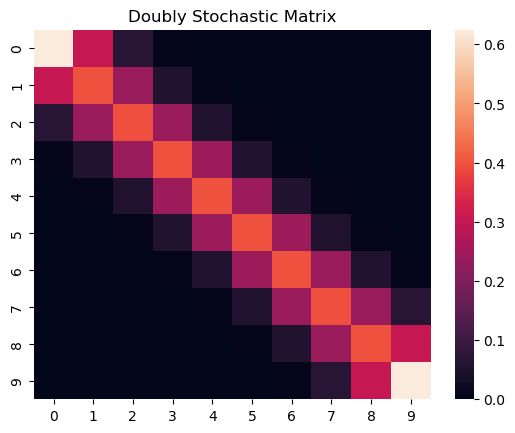

Row sums: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])
Column sums: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])


In [74]:
import ot

alpha = 2
cost = torch.zeros((num_categories, num_categories))

for i in range(num_categories):
    indices = torch.arange(num_categories).float()
    cost[i] = ((indices - i) ** 2)

# sns.heatmap(cost)    
# plt.show()

a = torch.ones(num_categories) / num_categories
b = torch.ones(num_categories) / num_categories

sinkhorn_matrix = ot.sinkhorn(a, b, M=cost, reg=alpha, nummaxiter=5000) * 10

sns.heatmap(sinkhorn_matrix)
plt.title("Doubly Stochastic Matrix")
plt.show()

sns.heatmap(sinkhorn_matrix)

## Model

In [8]:
forward_model = D3PM(
    input_dim=2,
    num_categories=num_categories, 
    num_timesteps=num_timesteps,
)
backward_model = D3PM(
    input_dim=2,
    num_categories=num_categories, 
    num_timesteps=numd_timesteps,
)

test_start = forward_model.sample(x_start, prior)
test_end = backward_model.sample(x_start, prior)

print(test_start, test_end)

NameError: name 'numd_timesteps' is not defined

# VQ prior

In [10]:
from dasbm.data import CelebaDataset
from dasbm.data import Prior
from dasbm.models.quantized_images import LatentD3PM, Codec

In [13]:
dataset = CelebaDataset(sex='male', data_dir='../data')
codec = Codec(
    config_path='../configs/vqgan_celeba_f8_1024.yaml',
    ckpt_path='../checkpoints/vqgan_celeba_f8_1024.ckpt',     
)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/beegfs/home/g.ksenofontov/Projects/dasbm/notebooks/../src/dasbm/models/quantized_images.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ckpt_pa

In [21]:
centroids = codec.model.quantize.embedding.weight.data
centroids.shape

torch.Size([1024, 256])

In [79]:
prior = Prior(
    alpha=1, 
    num_categories=1024, 
    num_timesteps=100, 
    num_skip_steps=1, 
    prior_type='centroid_gaussian',
    centroids=centroids
)

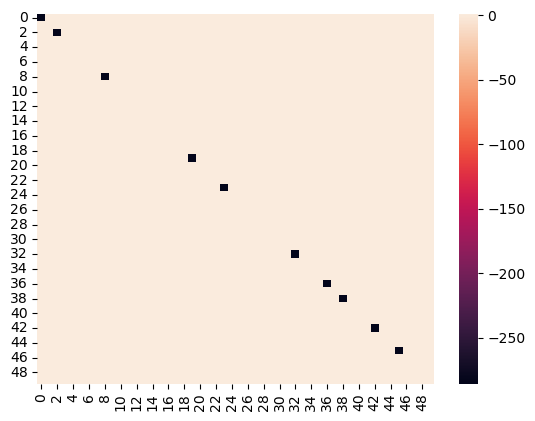

tensor(-84.4085, dtype=torch.float64) tensor(1.0000, dtype=torch.float64)


In [80]:
i = 1
sns.heatmap(prior.p_cum[i, :50, :50])
plt.show()
print(prior.p_onestep[i, 0].sum(), prior.p_onestep[i, 1].sum())